In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import lightgbm as lgb

# IMPORT

In [2]:
train = pd.read_csv('src/train.csv')
test = pd.read_csv('src/test.csv')

# CLEANING

In [3]:
# Select numerical columns
numerical_cols = ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']

# Select object columns
object_cols = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']

In [4]:
for col in object_cols:
    train[col].fillna(train[col].mode()[0], inplace=True)
    test[col].fillna(test[col].mode()[0], inplace=True)

for col in numerical_cols:
    train[col].fillna(train[col].median(), inplace=True)
    test[col].fillna(test[col].median(), inplace=True)


C:\Users\Feen_Phoorin\AppData\Local\Temp\ipykernel_15988\33391788.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train[col].fillna(train[col].mode()[0], inplace=True)
C:\Users\Feen_Phoorin\AppData\Local\Temp\ipykernel_15988\33391788.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39550 entries, 0 to 39549
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          39550 non-null  int64  
 1   person_age                  39550 non-null  float64
 2   person_income               39550 non-null  float64
 3   person_home_ownership       39550 non-null  object 
 4   person_emp_length           39550 non-null  float64
 5   loan_intent                 39550 non-null  object 
 6   loan_grade                  39550 non-null  object 
 7   loan_amnt                   39550 non-null  float64
 8   loan_int_rate               39550 non-null  float64
 9   loan_percent_income         39550 non-null  float64
 10  cb_person_default_on_file   39550 non-null  object 
 11  cb_person_cred_hist_length  39550 non-null  float64
 12  loan_status                 39550 non-null  int64  
dtypes: float64(7), int64(2), object

In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16950 entries, 0 to 16949
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          16950 non-null  int64  
 1   person_age                  16950 non-null  float64
 2   person_income               16950 non-null  float64
 3   person_home_ownership       16950 non-null  object 
 4   person_emp_length           16950 non-null  float64
 5   loan_intent                 16950 non-null  object 
 6   loan_grade                  16950 non-null  object 
 7   loan_amnt                   16950 non-null  float64
 8   loan_int_rate               16950 non-null  float64
 9   loan_percent_income         16950 non-null  float64
 10  cb_person_default_on_file   16950 non-null  object 
 11  cb_person_cred_hist_length  16950 non-null  float64
dtypes: float64(7), int64(1), object(4)
memory usage: 1.6+ MB


# Preprocessing

In [7]:
# Dropping of Unnecessary Columns
drop_cols = ["id"]
train.drop(columns=drop_cols, axis=1, inplace=True)
test.drop(columns=drop_cols, axis=1, inplace=True)

In [8]:
train['age_group'] = pd.cut(train['person_age'], bins=[18, 25, 35, 45, 55, 65, 100], labels=[1, 2, 3, 4, 5, 6])
test['age_group'] = pd.cut(test['person_age'], bins=[18, 25, 35, 45, 55, 65, 100], labels=[1, 2, 3, 4, 5, 6])

train['income_bin'] = pd.qcut(train['person_income'], q=5, labels=[1, 2, 3, 4, 5])
test['income_bin'] = pd.qcut(test['person_income'], q=5, labels=[1, 2, 3, 4, 5])

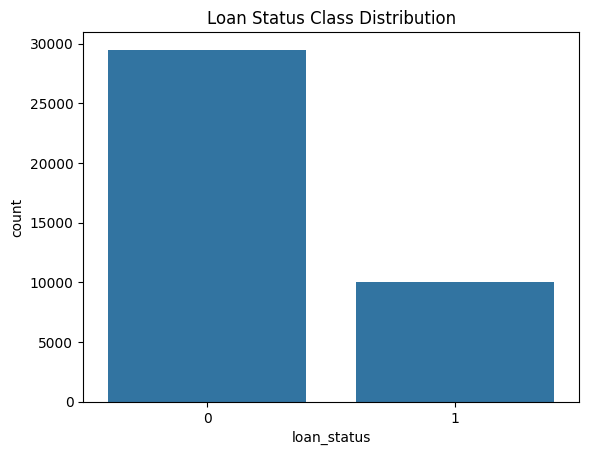

In [9]:
sns.countplot(x=train['loan_status'])
plt.title("Loan Status Class Distribution")
plt.show()

In [10]:
class_counts = train['loan_status'].value_counts()
class_counts

class_weights = {0: class_counts[1], 1: class_counts[0]}

In [11]:
label_encoders = {}
for col in object_cols:
    le = LabelEncoder()
    train[col] = le.fit_transform(train[col])
    test[col] = le.transform(test[col])
    label_encoders[col] = le

In [12]:
# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Select only numerical columns (you can exclude non-numerical ones like 'loan_status')
numerical_cols = test.select_dtypes(include=['float64', 'int64', 'category']).columns

# Scale numerical columns only
train[numerical_cols] = scaler.fit_transform(train[numerical_cols])
test[numerical_cols] = scaler.transform(test[numerical_cols])

In [13]:
train

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status,age_group,income_bin
0,0.111111,0.095801,1.0,0.236930,0.0,0.666667,0.530600,0.352058,0.348710,1.0,0.068966,1,0.2,0.00
1,0.244444,0.334324,0.0,0.339738,1.0,0.166667,0.545699,0.438426,0.330598,0.0,0.068966,0,0.2,1.00
2,0.088889,0.059691,1.0,0.195978,0.8,0.500000,0.274969,0.588007,0.436350,1.0,0.034483,0,0.0,0.00
3,0.022222,0.089218,1.0,0.136568,0.2,0.000000,0.336279,0.274750,0.358097,0.0,0.068966,0,0.0,0.00
4,0.066667,0.164456,1.0,0.113233,0.2,0.333333,0.174373,0.473544,0.335353,1.0,0.000000,1,0.0,0.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39545,0.200000,0.781914,0.0,0.553532,0.4,0.333333,0.146946,0.641554,0.235864,0.0,0.172414,0,0.2,1.00
39546,0.000000,0.276868,0.0,0.242301,0.2,0.166667,0.423050,0.320928,0.349580,0.0,0.000000,0,0.0,1.00
39547,0.177778,0.149785,1.0,0.234988,0.8,0.333333,0.537664,0.382813,0.600352,1.0,0.172414,1,0.2,0.25
39548,0.044444,0.054826,1.0,0.196408,0.8,0.500000,0.194764,0.661261,0.417522,1.0,0.034483,1,0.0,0.00


In [14]:
test

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,age_group,income_bin
0,0.022222,0.078558,1.000000,0.247858,0.6,0.333333,0.550519,0.542674,0.682922,1.0,0.068966,0.0,0.00
1,0.222222,0.285087,0.000000,0.393477,1.0,0.000000,0.325003,0.307457,0.245059,0.0,0.275862,0.2,1.00
2,0.088889,0.064400,1.000000,0.105315,0.6,0.333333,0.231694,0.555079,0.065056,0.0,0.068966,0.0,0.00
3,0.088889,0.173037,0.000000,0.348055,0.0,0.000000,0.658706,0.169218,0.237382,0.0,0.068966,0.0,0.50
4,0.133333,0.318693,0.000000,0.198650,0.8,0.000000,0.164427,0.061280,0.115112,0.0,0.000000,0.2,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16945,0.044444,0.157554,1.000000,0.196605,0.2,0.500000,0.324810,0.461813,0.341016,0.0,0.068966,0.0,0.50
16946,0.200000,0.231280,0.000000,0.470544,0.0,0.500000,0.140518,0.633286,0.163253,1.0,0.206897,0.2,0.75
16947,0.244444,0.098136,1.000000,0.448694,1.0,0.333333,0.203574,0.342667,0.364637,0.0,0.137931,0.2,0.25
16948,0.022222,0.161607,0.333333,0.001523,0.0,0.166667,0.325502,0.366217,0.413378,0.0,0.068966,0.0,0.50


# Training

## - LightGBM (0.68674) with feature engineering, weight class and max min scaling AND 100% training

In [15]:
X = train.drop('loan_status', axis=1)
y = train['loan_status']

clf = lgb.LGBMClassifier(
    class_weight=class_weights,
    random_state=42
)

clf.fit(X, y)

[LightGBM] [Info] Number of positive: 10053, number of negative: 29497
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000435 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1377
[LightGBM] [Info] Number of data points in the train set: 39550, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


LGBMClassifier(class_weight={0: np.int64(10053), 1: np.int64(29497)},
               random_state=42)

## - LightGBM (0.68062) with feature engineering, weight class and max min scaling

In [16]:
# X = train.drop('loan_status', axis=1)
# y = train['loan_status']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# clf = lgb.LGBMClassifier(
#     class_weight=class_weights,
#     random_state=42
# )

# clf.fit(X_train, y_train)

# y_pred = clf.predict(X_test)

## - LightGBM (0.66598)

In [17]:
# X = train.drop('loan_status', axis=1)
# y = train['loan_status']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# clf = lgb.LGBMClassifier(
#     random_state=42
# )

# clf.fit(X_train, y_train)

# y_pred = clf.predict(X_test)

## - XGboosts (0.66546)

In [18]:
# X = train_df.drop('loan_status', axis=1)
# y = train_df['loan_status']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# clf = XGBClassifier(
#     colsample_bytree=0.9,
#     learning_rate=0.1,
#     max_depth=3,
#     n_estimators=200,
#     subsample=0.9,
#     eval_metric='logloss',
#     random_state=42
# )

# clf.fit(X_train, y_train)

# y_pred = clf.predict(X_test)

# Evaluate

In [19]:
# print('Evaluation')

# accuracy = accuracy_score(y_test, y_pred)
# print(f"Accuracy: {accuracy:.2f}")

# print("Classification Report:")
# print(classification_report(y_test, y_pred))

# Predict test case

In [20]:
y_pred = clf.predict(test)
y_pred

array([1, 0, 1, ..., 0, 1, 0], shape=(16950,))

In [21]:
submit_df = pd.read_csv('src/sample_submission.csv')
submit_df

,id,loan_status
0,39550,1.0
1,39551,0.0
2,39552,1.0
3,39553,NaN
4,39554,NaN
...,...,...
16945,56495,NaN
16946,56496,NaN
16947,56497,NaN
16948,56498,NaN


In [22]:
submit_df['loan_status'] = y_pred

In [23]:
submit_df.to_csv('submission.csv', index=False)

submit_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16950 entries, 0 to 16949
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   id           16950 non-null  int64
 1   loan_status  16950 non-null  int64
dtypes: int64(2)
memory usage: 265.0 KB


# Other

In [24]:
current_submit_df = pd.read_csv('submission.csv')
previous_submit_df = pd.read_csv('submission0.68674.csv')

In [25]:
current_submit_df

,id,loan_status
0,39550,1
1,39551,0
2,39552,1
3,39553,0
4,39554,0
...,...,...
16945,56495,1
16946,56496,1
16947,56497,0
16948,56498,1


In [26]:
previous_submit_df

,id,loan_status
0,39550,1
1,39551,0
2,39552,1
3,39553,0
4,39554,0
...,...,...
16945,56495,1
16946,56496,1
16947,56497,0
16948,56498,1


In [27]:
# Initialize a counter for differences
diff_count = 0

# Iterate over all rows
for i in range(len(current_submit_df)):
    # Get loan_status values for the current row in both dataframes
    current_loan_status = current_submit_df.iloc[i]['loan_status']
    previous_loan_status = previous_submit_df.iloc[i]['loan_status']
    
    # Compare the loan_status values
    if current_loan_status != previous_loan_status:
        # Print the id and the differing loan_status
        id_value = current_submit_df.iloc[i]['id']
        print(f"Id: {id_value} has different loan_status values -> Current: {current_loan_status}, Previous: {previous_loan_status}")
        diff_count += 1

# Print total number of differences
print(f"Total differences: {diff_count}")


Total differences: 0
